In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
import random
import folium
from folium.plugins import MarkerCluster
from IPython.display import display, HTML
from folium.plugins import HeatMap
import seaborn as sns
import plotly.graph_objects as go
from pandas.plotting import scatter_matrix
import io
# 
from tensorflow.keras import layers, models
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# from sklearn.base import BaseEstimator, TransformerMixin

color = sns.color_palette()


# tf and keras
import tensorflow as tf
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

random.seed(42)

In [65]:
# Base path
base_path = "./data/"

# Read data
properties_2016 = pd.read_csv(f'{base_path}properties_2016.csv')
properties_2017 = pd.read_csv(f'{base_path}properties_2017.csv')
train_2016 = pd.read_csv(f'{base_path}train_2016_v2.csv')
train_2017 = pd.read_csv(f'{base_path}train_2017.csv')

# Concatenate train datasets
df_logs = pd.concat([train_2016, train_2017])

# Concatenate properties datasets
properties = pd.concat([properties_2016, properties_2017])

# Merge train data with properties data
df = pd.merge(df_logs, properties, on='parcelid', how='inner')

# Convert transactiondate to datetime
df['transactiondate'] = pd.to_datetime(df['transactiondate'])

# Perform train_test_split with shuffle=False to maintain order
train_df, valid_df = train_test_split(df, test_size=0.2, shuffle=False)

/var/folders/m3/jn87_n2s6cnbxdsks7gkhs7m0000gn/T/ipykernel_74694/3119019793.py:5: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  properties_2016 = pd.read_csv(f'{base_path}properties_2016.csv')
/var/folders/m3/jn87_n2s6cnbxdsks7gkhs7m0000gn/T/ipykernel_74694/3119019793.py:6: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  properties_2017 = pd.read_csv(f'{base_path}properties_2017.csv')


In [66]:
class RandomChoiceImputer(BaseEstimator, TransformerMixin):
    def __init__(self, choices):
        self.choices = choices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for column in X.columns:
            missing_indices = X[column].isnull()
            num_missing = missing_indices.sum()
            if num_missing > 0:
                X.loc[missing_indices, column] = np.random.choice(self.choices, size=num_missing)
        return X

In [67]:
imputation_strategies = {
    'bathroomcnt': 'most_frequent',
    'bedroomcnt': 'median',
    'calculatedbathnbr': 'median',
    'calculatedfinishedsquarefeet': 'median',
    'fireplacecnt': 0,  # Impute with specific number
    'fullbathcnt': 'median',
    'garagecarcnt': 'iterative',
    'latitude': 'median',
    'longitude': 'median',
    'lotsizesquarefeet': 'iterative',
    'poolcnt': 0,
    'propertylandusetypeid': 'most_frequent',  # Type of land use the property is zoned for
    'regionidcounty': 'most_frequent',
    'regionidzip': 'drop',  # Drop rows with missing values in this column
    'roomcnt': 'drop',
    'yearbuilt': 'drop',
    'numberofstories': 0,  # Zero missing from unique values
    'structuretaxvaluedollarcnt': 'iterative',
    'taxvaluedollarcnt': 'iterative',
    'assessmentyear': 'random',
    'landtaxvaluedollarcnt': 'iterative',
    'taxamount': 'iterative',
    'censustractandblock': 'random',
}

numerical_features = [
    'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet',
    'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
    'poolcnt', 'roomcnt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
    'landtaxvaluedollarcnt', 'taxamount'
]

categorical_features = [
    'propertylandusetypeid', 'regionidcounty', 'regionidzip', 'yearbuilt', 'assessmentyear',
    'censustractandblock'
]

In [68]:
count = 0
for i in imputation_strategies.items():
    count += 1
print(f"number of columns in imputation strategies {count}")

number of columns in imputation strategies 23


In [69]:
invalid_keys = [k for k in imputation_strategies if k not in numerical_features and k not in categorical_features]
invalid_keys

[]

In [70]:
print(len(numerical_features + categorical_features))

23


In [71]:

# Select relevant columns
columns_to_keep = list(imputation_strategies.keys()) + ['transactiondate', 'logerror']
train_df_selected = train_df[columns_to_keep].copy()
valid_df_selected = valid_df[columns_to_keep].copy()

# Initialize imputers
imputers = {}

# Apply imputation strategies to the training set
for column, strategy in imputation_strategies.items():
    if strategy == 'drop':
        train_df_selected = train_df_selected.dropna(subset=[column])
    elif strategy == 'most_frequent':
        imputers[column] = SimpleImputer(strategy='most_frequent')
        train_df_selected[column] = imputers[column].fit_transform(train_df_selected[[column]])
    elif strategy == 'median':
        imputers[column] = SimpleImputer(strategy='median')
        train_df_selected[column] = imputers[column].fit_transform(train_df_selected[[column]])
    elif isinstance(strategy, (int, float)):
        imputers[column] = SimpleImputer(strategy='constant', fill_value=strategy)
        train_df_selected[column] = imputers[column].fit_transform(train_df_selected[[column]])
    elif strategy == 'random':
        unique_values = train_df_selected[column].dropna().unique().tolist()
        imputers[column] = RandomChoiceImputer(choices=unique_values)
        train_df_selected[[column]] = imputers[column].fit_transform(train_df_selected[[column]])

# Apply IterativeImputer to the relevant columns in the training set
iterative_columns = [column for column, strategy in imputation_strategies.items() if strategy == 'iterative']
if iterative_columns:
    iterative_imputer = IterativeImputer()
    train_df_selected[iterative_columns] = iterative_imputer.fit_transform(train_df_selected[iterative_columns])

# Apply the same imputation strategies to the validation set
for column, strategy in imputation_strategies.items():
    if strategy == 'drop':
        valid_df_selected = valid_df_selected.dropna(subset=[column])
    elif strategy == 'most_frequent' or strategy == 'median' or isinstance(strategy, (int, float)):
        valid_df_selected[column] = imputers[column].transform(valid_df_selected[[column]])
    elif strategy == 'random':
        valid_df_selected[[column]] = imputers[column].transform(valid_df_selected[[column]])

# Apply IterativeImputer to the relevant columns in the validation set
if iterative_columns:
    valid_df_selected[iterative_columns] = iterative_imputer.transform(valid_df_selected[iterative_columns])

In [72]:
train_df_selected.columns
train_df_selected

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,propertylandusetypeid,regionidcounty,regionidzip,roomcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate,logerror
0,2.0,3.0,2.0,1684.0,0.0,2.0,1.663683,34280990.0,-118488536.0,7528.000000,0.0,261.0,3101.0,96370.0,0.0,1959.0,0.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13,2016-01-01,0.027600
1,2.0,3.0,2.0,1684.0,0.0,2.0,1.844166,34280990.0,-118488536.0,7528.000000,0.0,261.0,3101.0,96370.0,0.0,1959.0,0.0,218000.0,545000.0,2016.0,327000.0,6735.88,6.037107e+13,2016-01-01,0.027600
2,3.5,4.0,3.5,2263.0,0.0,3.0,2.000000,33668120.0,-117677556.0,3643.000000,0.0,261.0,1286.0,96962.0,0.0,2014.0,0.0,346458.0,585529.0,2015.0,239071.0,10153.02,6.037432e+13,2016-01-01,-0.168400
3,3.5,4.0,3.5,2263.0,0.0,3.0,2.000000,33668120.0,-117677556.0,3643.000000,0.0,261.0,1286.0,96962.0,0.0,2014.0,0.0,346458.0,974900.0,2016.0,628442.0,10153.02,6.037106e+13,2016-01-01,-0.168400
4,3.5,4.0,3.5,2263.0,0.0,3.0,2.000000,33668120.0,-117677556.0,3643.000000,0.0,261.0,1286.0,96962.0,0.0,2014.0,0.0,346458.0,585529.0,2015.0,239071.0,10153.02,6.059042e+13,2017-08-04,0.002142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268615,2.5,3.0,2.5,1483.0,0.0,2.0,1.000000,33590434.0,-117645082.0,32788.943832,0.0,266.0,1286.0,96996.0,0.0,1994.0,0.0,206609.0,338585.0,2016.0,131976.0,3241.88,6.059032e+13,2017-06-02,-0.039885
268616,1.0,2.0,1.0,1350.0,0.0,1.0,1.665921,34090353.0,-117970808.0,7503.000000,0.0,261.0,3101.0,96465.0,0.0,1949.0,0.0,85317.0,132712.0,2015.0,47395.0,1925.15,6.037405e+13,2017-06-02,-0.047014
268617,1.0,2.0,1.0,1350.0,0.0,1.0,1.668295,34090353.0,-117970808.0,7503.000000,0.0,261.0,3101.0,96465.0,0.0,1949.0,0.0,86618.0,134735.0,2016.0,48117.0,1925.15,6.037405e+13,2017-06-02,-0.047014
268618,1.0,2.0,1.0,890.0,0.0,1.0,1.609413,33933232.0,-118213826.0,3275.000000,0.0,261.0,3101.0,96113.0,0.0,1930.0,0.0,58000.0,292000.0,2015.0,234000.0,4039.30,6.037540e+13,2017-06-02,0.011533


In [73]:
valid_df_selected

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,propertylandusetypeid,regionidcounty,regionidzip,roomcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate,logerror
268620,3.0,3.0,3.0,2182.0,0.0,3.0,2.046741,34044387.0,-117907759.0,5488.0,0.0,269.0,3101.0,96524.0,0.0,2008.0,0.0,346195.0,653602.0,2015.0,307407.0,7473.86,6.037408e+13,2017-06-02,0.001077
268621,3.0,3.0,3.0,2182.0,0.0,3.0,2.056694,34044387.0,-117907759.0,5488.0,0.0,269.0,3101.0,96524.0,0.0,2008.0,0.0,351474.0,663568.0,2016.0,312094.0,7473.86,6.037408e+13,2017-06-02,0.001077
268622,5.0,5.0,5.0,3427.0,0.0,5.0,2.014133,34133176.0,-118611368.0,13054.0,1.0,269.0,3101.0,96337.0,0.0,1988.0,0.0,355000.0,1398000.0,2015.0,1043000.0,15976.25,6.037800e+13,2017-06-02,0.065176
268623,5.0,5.0,5.0,3427.0,0.0,5.0,2.014133,34133176.0,-118611368.0,13054.0,1.0,269.0,3101.0,96337.0,0.0,1988.0,0.0,355000.0,1398000.0,2016.0,1043000.0,15976.25,6.037800e+13,2017-06-02,0.065176
268624,4.0,5.0,4.0,2839.0,0.0,4.0,1.954930,34144844.0,-117896342.0,6807.0,0.0,261.0,3101.0,96464.0,0.0,2007.0,0.0,371476.0,668086.0,2015.0,296610.0,13796.38,6.037401e+13,2017-06-02,-0.008875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335771,2.0,4.0,2.0,1612.0,1.0,2.0,2.000000,34300140.0,-118706327.0,12105.0,0.0,261.0,2061.0,97116.0,7.0,1964.0,1.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,2017-09-21,0.013209
335772,1.0,3.0,1.0,1032.0,0.0,1.0,1.591696,34040895.0,-118038169.0,5074.0,0.0,261.0,3101.0,96480.0,0.0,1954.0,0.0,32305.0,48803.0,2015.0,16498.0,876.43,6.037434e+13,2017-09-21,0.037129
335773,1.0,3.0,1.0,1032.0,0.0,1.0,1.592590,34040895.0,-118038169.0,5074.0,0.0,261.0,3101.0,96480.0,0.0,1954.0,0.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,2017-09-21,0.037129
335774,2.0,3.0,2.0,1762.0,0.0,2.0,1.711197,33937685.0,-117996709.0,6347.0,0.0,261.0,3101.0,96171.0,0.0,1955.0,0.0,132000.0,493000.0,2015.0,361000.0,6317.15,6.037503e+13,2017-09-25,0.007204


In [74]:
# Scale numerical features using MinMaxScaler
scalers = {}
for column in numerical_features:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_df_selected[column] = scaler.fit_transform(train_df_selected[[column]])
    scalers[column] = scaler

# Apply the same scaling to the validation set
for column in numerical_features:
    valid_df_selected[column] = scalers[column].transform(valid_df_selected[[column]])

# Encode categorical features using LabelEncoder (for embeddings in neural networks)
class SafeLabelEncoder(LabelEncoder):
    def transform(self, y):
        classes = np.unique(y)
        unseen_labels = set(classes) - set(self.classes_)
        if unseen_labels:
            raise ValueError(f"y contains previously unseen labels: {str(unseen_labels)}")
        return super().transform(y)

encoders = {}
for column in categorical_features:
    encoder = LabelEncoder()
    train_df_selected[column] = encoder.fit_transform(train_df_selected[column])
    encoders[column] = encoder
    
    # Handle unseen labels in validation set by encoding them to -1
    valid_df_selected[column] = valid_df_selected[column].apply(lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1)

In [75]:

# Define features and target
features = numerical_features + categorical_features
target = 'logerror'

X_train = train_df_selected[features]
Y_train = train_df_selected[target]
X_val = valid_df_selected[features]
Y_val = valid_df_selected[target]

# Standardize target variable
Y_train_std = (Y_train - Y_train.mean()) / Y_train.std()
Y_val_std = (Y_val - Y_train.mean()) / Y_train.std()

In [76]:
def build_model(lr):
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    random.seed(42)

    inputs = {}
    for feature in numerical_features + categorical_features:
        inputs[feature] = layers.Input(shape=(1,), dtype=tf.float32, name=feature)

    concatenated_features = layers.Concatenate()(list(inputs.values()))

    x = layers.Dense(units=600, kernel_initializer='normal', activation='relu')(concatenated_features)
    x = layers.Dropout(0.36)(x)
    x = layers.Dense(units=200, kernel_initializer='normal', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(1, kernel_initializer='normal')(x)

    logerror = layers.Dense(units=1, activation='linear', name='logerror')(x)

    model = models.Model(inputs=inputs, outputs=logerror)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mae', metrics=['mae'])

    return model

model = build_model(lr=0.002)


history = model.fit(
    x={feature: X_train[feature].values for feature in numerical_features + categorical_features},
    y=Y_train_std,
    epochs=5,
    batch_size=128,
    validation_data=(
        {feature: X_val[feature].values for feature in numerical_features + categorical_features},
        Y_val_std
    )
)

val_preds = model.predict({feature: X_val[feature].values for feature in numerical_features + categorical_features})

# Convert predictions to original scale
val_preds = (val_preds[:, 0] * Y_train.std()) + Y_train.mean()

def get_loss(y_true, y_pred):
    return tf.keras.losses.MAE(y_true, y_pred).numpy()

# Evaluate model performance
mae = get_loss(Y_val, val_preds)
print(f'Mean Absolute Error on Validation Set: {mae}')



Epoch 1/5
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4757 - mae: 0.4757 - val_loss: 0.4232 - val_mae: 0.4232
Epoch 2/5
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4257 - mae: 0.4257 - val_loss: 0.4189 - val_mae: 0.4189
Epoch 3/5
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4246 - mae: 0.4246 - val_loss: 0.4189 - val_mae: 0.4189
Epoch 4/5
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4246 - mae: 0.4246 - val_loss: 0.4188 - val_mae: 0.4188
Epoch 5/5
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4246 - mae: 0.4246 - val_loss: 0.4189 - val_mae: 0.4189
2087/2087 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step
Mean Absolute Error on Validation Set: 0.06766028702259064


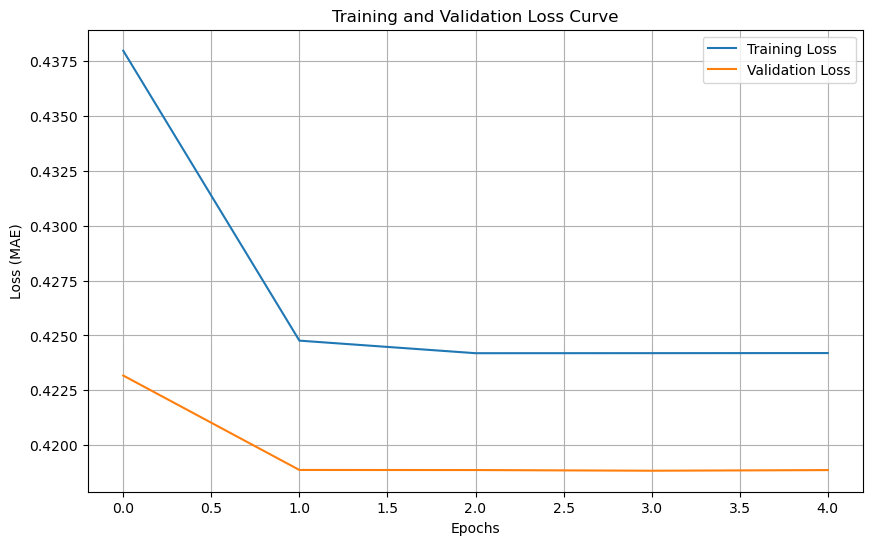

In [77]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the training history of Model 2
def plot_loss_curve(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MAE)')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the loss curve
plot_loss_curve(history)


In [78]:
{feature: X_val[feature].values for feature in numerical_features + categorical_features}

{'bathroomcnt': array([-0.7, -0.7, -0.5, ..., -0.9, -0.8, -0.8]),
 'bedroomcnt': array([-0.625, -0.625, -0.375, ..., -0.625, -0.625, -0.625]),
 'calculatedbathnbr': array([-0.78947368, -0.78947368, -0.57894737, ..., -1.        ,
        -0.89473684, -0.89473684]),
 'calculatedfinishedsquarefeet': array([-0.87765868, -0.87765868, -0.80778944, ..., -0.94219653,
        -0.90122903, -0.90122903]),
 'fireplacecnt': array([-1., -1., -1., ..., -1., -1., -1.]),
 'fullbathcnt': array([-0.78947368, -0.78947368, -0.57894737, ..., -1.        ,
        -0.89473684, -0.89473684]),
 'garagecarcnt': array([-0.7091833 , -0.70840842, -0.71172204, ..., -0.74454147,
        -0.73530725, -0.73393678]),
 'latitude': array([-0.04505273, -0.04505273,  0.0751994 , ..., -0.04978215,
        -0.18956548, -0.18956548]),
 'longitude': array([ 0.63228401,  0.63228401, -0.100402  , ...,  0.49648475,
         0.5396581 ,  0.5396581 ]),
 'lotsizesquarefeet': array([-0.78246167, -0.78246167, -0.78052555, ..., -0.78256

In [79]:
from tensorflow.keras.callbacks import EarlyStopping

def build_model(lr):
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    random.seed(42)

    inputs = {}
    for feature in numerical_features + categorical_features:
        inputs[feature] = layers.Input(shape=(1,), dtype=tf.float32, name=feature)

    concatenated_features = layers.Concatenate()(list(inputs.values()))

    x = layers.Dense(units=1024, kernel_initializer='normal', activation='relu')(concatenated_features)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(units=512, kernel_initializer='normal', activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(units=256, kernel_initializer='normal', activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(units=128, kernel_initializer='normal', activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, kernel_initializer='normal')(x)

    logerror = layers.Dense(units=1, activation='linear', name='logerror')(x)

    model = models.Model(inputs=inputs, outputs=logerror)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mae', metrics=['mae'])

    return model

model = build_model(lr=0.001)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x={feature: X_train[feature].values for feature in numerical_features + categorical_features},
    y=Y_train_std,
    epochs=100,
    batch_size=256,
    validation_data=(
        {feature: X_val[feature].values for feature in numerical_features + categorical_features},
        Y_val_std
    ),
    callbacks=[early_stopping]
)

val_preds = model.predict({feature: X_val[feature].values for feature in numerical_features + categorical_features})

# Convert predictions to original scale
val_preds = (val_preds[:, 0] * Y_train.std()) + Y_train.mean()

def get_loss(y_true, y_pred):
    return tf.keras.losses.MAE(y_true, y_pred).numpy()

# Evaluate model performance
mae = get_loss(Y_val, val_preds)
print(f'Mean Absolute Error on Validation Set: {mae}')

# Load the sample submission file
submission_df = pd.read_csv(f'{base_path}sample_submission.csv')

Epoch 1/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 50.8076 - mae: 50.8076 - val_loss: 0.4188 - val_mae: 0.4188
Epoch 2/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.4505 - mae: 0.4505 - val_loss: 0.4187 - val_mae: 0.4187
Epoch 3/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.4324 - mae: 0.4324 - val_loss: 0.4189 - val_mae: 0.4189
Epoch 4/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.4294 - mae: 0.4294 - val_loss: 0.4189 - val_mae: 0.4189
Epoch 5/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.4262 - mae: 0.4262 - val_loss: 0.4189 - val_mae: 0.4189
Epoch 6/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.4255 - mae: 0.4255 - val_loss: 0.4189 - val_mae: 0.4189
Epoch 7/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.4252 - mae: 0.4252 - val_loss: 0.4189 - val_mae: 0.4189
Epoch 8/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.4256 - mae: 0.4256 - val_loss: 0.4189 - val_mae: 0.4189
Epoch 9/100
1043/1043 ━━━━━━━━

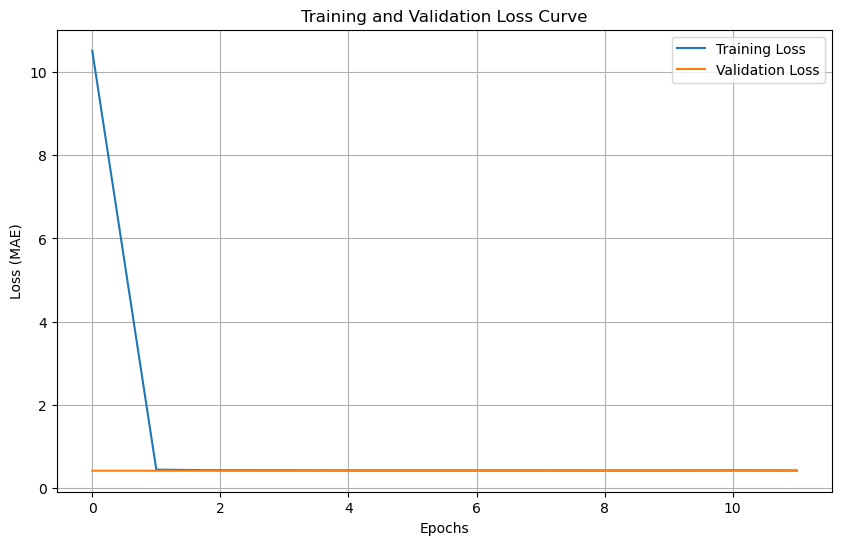

In [80]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable storing the training history of Model 2
def plot_loss_curve(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MAE)')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the loss curve
plot_loss_curve(history)


In [22]:
# Load the sample submission file
submission_df = pd.read_csv(f'{base_path}sample_submission.csv')

# Read data
properties_2016 = pd.read_csv(f'{base_path}properties_2016.csv')
properties_2017 = pd.read_csv(f'{base_path}properties_2017.csv')
train_2016 = pd.read_csv(f'{base_path}train_2016_v2.csv')
train_2017 = pd.read_csv(f'{base_path}train_2017.csv')

# Concatenate train datasets
df_logs = pd.concat([train_2016, train_2017])

# Concatenate properties datasets
properties = pd.concat([properties_2016, properties_2017])

# Merge train data with properties data
df = pd.merge(df_logs, properties, on='parcelid', how='inner')

# Convert transactiondate to datetime
df['transactiondate'] = pd.to_datetime(df['transactiondate'])


# Filter the main df to keep only relevant columns
df = df[columns_to_keep + ['parcelid']]

/var/folders/m3/jn87_n2s6cnbxdsks7gkhs7m0000gn/T/ipykernel_74694/1023551344.py:5: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  properties_2016 = pd.read_csv(f'{base_path}properties_2016.csv')
/var/folders/m3/jn87_n2s6cnbxdsks7gkhs7m0000gn/T/ipykernel_74694/1023551344.py:6: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  properties_2017 = pd.read_csv(f'{base_path}properties_2017.csv')


In [27]:
df

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,propertylandusetypeid,regionidcounty,regionidzip,roomcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate,logerror,parcelid
0,2.0,3.0,2.0,1684.0,NaN,2.0,NaN,34280990.0,-118488536.0,7528.0,NaN,261.0,3101.0,96370.0,0.0,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13,2016-01-01,0.027600,11016594
1,2.0,3.0,2.0,1684.0,NaN,2.0,NaN,34280990.0,-118488536.0,7528.0,NaN,261.0,3101.0,96370.0,0.0,1959.0,NaN,218000.0,545000.0,2016.0,327000.0,6735.88,6.037107e+13,2016-01-01,0.027600,11016594
2,3.5,4.0,3.5,2263.0,NaN,3.0,2.0,33668120.0,-117677556.0,3643.0,NaN,261.0,1286.0,96962.0,0.0,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,2016-01-01,-0.168400,14366692
3,3.5,4.0,3.5,2263.0,NaN,3.0,2.0,33668120.0,-117677556.0,3643.0,NaN,261.0,1286.0,96962.0,0.0,2014.0,NaN,346458.0,974900.0,2016.0,628442.0,10153.02,NaN,2016-01-01,-0.168400,14366692
4,3.5,4.0,3.5,2263.0,NaN,3.0,2.0,33668120.0,-117677556.0,3643.0,NaN,261.0,1286.0,96962.0,0.0,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,2017-08-04,0.002142,14366692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335771,2.0,4.0,2.0,1612.0,1.0,2.0,2.0,34300140.0,-118706327.0,12105.0,NaN,261.0,2061.0,97116.0,7.0,1964.0,1.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,2017-09-21,0.013209,17239384
335772,1.0,3.0,1.0,1032.0,NaN,1.0,NaN,34040895.0,-118038169.0,5074.0,NaN,261.0,3101.0,96480.0,0.0,1954.0,NaN,32305.0,48803.0,2015.0,16498.0,876.43,6.037434e+13,2017-09-21,0.037129,12773139
335773,1.0,3.0,1.0,1032.0,NaN,1.0,NaN,34040895.0,-118038169.0,5074.0,NaN,261.0,3101.0,96480.0,0.0,1954.0,NaN,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,2017-09-21,0.037129,12773139
335774,2.0,3.0,2.0,1762.0,NaN,2.0,NaN,33937685.0,-117996709.0,6347.0,NaN,261.0,3101.0,96171.0,0.0,1955.0,NaN,132000.0,493000.0,2015.0,361000.0,6317.15,6.037503e+13,2017-09-25,0.007204,12826780


In [36]:
# Load the sample submission file
submission_df = pd.read_csv(f'{base_path}sample_submission.csv')

common_parcel_ids = np.intersect1d(submission_df['ParcelId'], df['parcelid'])
filtered_submission_df = submission_df[submission_df['ParcelId'].isin(common_parcel_ids)].copy()
parcel_ids_from_submission_file = filtered_submission_df.ParcelId.unique().tolist()

df_submission = df[df['parcelid'].isin(parcel_ids_from_submission_file)]

df_submission = df_submission.drop_duplicates(subset=['parcelid']).set_index('parcelid')
df_submission

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,propertylandusetypeid,regionidcounty,regionidzip,roomcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate,logerror
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,
11016594,2.0,3.0,2.0,1684.0,NaN,2.0,NaN,34280990.0,-118488536.0,7528.0,NaN,261.0,3101.0,96370.0,0.0,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13,2016-01-01,0.027600
14366692,3.5,4.0,3.5,2263.0,NaN,3.0,2.0,33668120.0,-117677556.0,3643.0,NaN,261.0,1286.0,96962.0,0.0,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,2016-01-01,-0.168400
12098116,3.0,2.0,3.0,2217.0,NaN,3.0,NaN,34136312.0,-118175032.0,11423.0,NaN,261.0,3101.0,96293.0,0.0,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13,2016-01-01,-0.004000
12643413,2.0,2.0,2.0,839.0,NaN,2.0,NaN,33755800.0,-118309000.0,70859.0,NaN,266.0,3101.0,96222.0,0.0,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13,2016-01-02,0.021800
14432541,2.5,4.0,2.5,2283.0,NaN,2.0,2.0,33485643.0,-117700234.0,6000.0,1.0,261.0,1286.0,96961.0,8.0,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13,2016-01-02,-0.005000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10833991,3.0,3.0,3.0,1741.0,NaN,3.0,NaN,34202400.0,-118502000.0,59487.0,1.0,266.0,3101.0,96415.0,0.0,1980.0,NaN,143178.0,203793.0,2015.0,60615.0,4685.34,6.037132e+13,2017-09-20,-0.002245
11000655,2.0,2.0,2.0,1286.0,NaN,2.0,NaN,34245368.0,-118282383.0,47405.0,NaN,261.0,3101.0,96284.0,0.0,1940.0,NaN,69852.0,349295.0,2015.0,279443.0,4478.43,6.037101e+13,2017-09-20,0.020615
17239384,2.0,4.0,2.0,1612.0,1.0,2.0,2.0,34300140.0,-118706327.0,12105.0,NaN,261.0,2061.0,97116.0,7.0,1964.0,1.0,49923.0,66198.0,2015.0,16275.0,1065.18,6.111008e+13,2017-09-21,0.013209


In [43]:
# Apply the same imputation strategies to the validation set
for column, strategy in imputation_strategies.items():
    if strategy == 'drop':
        df_submission = df_submission.dropna(subset=[column])
    elif strategy == 'most_frequent' or strategy == 'median' or isinstance(strategy, (int, float)):
        df_submission[column] = imputers[column].transform(df_submission[[column]])
    elif strategy == 'random':
        df_submission[[column]] = imputers[column].transform(df_submission[[column]])

# Apply IterativeImputer to the relevant columns in the validation set
if iterative_columns:
    df_submission[iterative_columns] = iterative_imputer.transform(df_submission[iterative_columns])


# Apply the same scaling to the validation set
for column in numerical_features:
    df_submission[column] = scalers[column].transform(df_submission[[column]])

# Encode categorical features using LabelEncoder (for embeddings in neural networks)
class SafeLabelEncoder(LabelEncoder):
    def transform(self, y):
        classes = np.unique(y)
        unseen_labels = set(classes) - set(self.classes_)
        if unseen_labels:
            raise ValueError(f"y contains previously unseen labels: {str(unseen_labels)}")
        return super().transform(y)

for column in categorical_features:
    # Handle unseen labels in validation set by encoding them to -1
    df_submission[column] = df_submission[column].apply(lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1)

In [45]:
df_submission2 = df_submission.copy()

In [46]:
df_submission2.drop('logerror', axis=1, inplace=True)

In [51]:
df_submission2

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,propertylandusetypeid,regionidcounty,regionidzip,roomcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate
parcelid,,,,,,,,,,,,,,,,,,,,,,,,
11016594,-0.80,-0.625,-0.894737,-0.905606,-1.0,-0.894737,-0.739006,0.275393,0.027506,-0.781940,-1.0,-1,-1,-1,-1.000000,-1,-1.0,-0.984150,-0.985318,-1,-0.990301,-0.977103,810,2016-01-01
14366692,-0.65,-0.500,-0.736842,-0.873113,-1.0,-0.789474,-0.712822,-0.554653,0.872000,-0.782934,-1.0,-1,-1,-1,-1.000000,-1,-1.0,-0.955264,-0.976132,-1,-0.990233,-0.965453,23679,2016-01-01
12098116,-0.70,-0.750,-0.789474,-0.875694,-1.0,-0.789474,-0.757568,0.079447,0.353966,-0.780943,-1.0,-1,-1,-1,-1.000000,-1,-1.0,-0.991995,-0.995113,-1,-0.997635,-0.960913,19708,2016-01-01
12643413,-0.80,-0.750,-0.894737,-0.953028,-1.0,-0.894737,-0.730195,-0.435903,0.214462,-0.765733,-1.0,-1,-1,-1,-1.000000,-1,-1.0,-0.977853,-0.990018,-1,-0.997004,-0.989674,12146,2016-01-02
14432541,-0.75,-0.500,-0.842105,-0.871991,-1.0,-0.894737,-0.712822,-0.801792,0.848385,-0.782331,1.0,-1,-1,-1,-0.111111,-1,0.0,-0.978104,-0.982286,-1,-0.989175,-0.981354,40122,2016-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10833991,-0.70,-0.625,-0.789474,-0.902408,-1.0,-0.789474,-0.736599,0.168954,0.013486,-0.768643,1.0,-1,-1,-1,-1.000000,-1,-1.0,-0.981512,-0.991693,-1,-0.997524,-0.984094,3606,2017-09-20
11000655,-0.80,-0.750,-0.894737,-0.927942,-1.0,-0.894737,-0.742736,0.227148,0.242178,-0.771735,-1.0,-1,-1,-1,-1.000000,-1,-1.0,-0.990980,-0.985762,-1,-0.988584,-0.984799,119,2017-09-20
17239384,-0.80,-0.500,-0.894737,-0.909647,-0.6,-0.894737,-0.712822,0.301328,-0.199285,-0.780768,-1.0,-1,-1,-1,-0.222222,-1,-0.5,-0.993554,-0.997302,-1,-0.999336,-0.996436,51583,2017-09-21


In [53]:
df_submission3 = df_submission2.head(1).copy()
df_submission3

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fireplacecnt,fullbathcnt,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,propertylandusetypeid,regionidcounty,regionidzip,roomcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate
parcelid,,,,,,,,,,,,,,,,,,,,,,,,
11016594,-0.8,-0.625,-0.894737,-0.905606,-1.0,-0.894737,-0.739006,0.275393,0.027506,-0.78194,-1.0,-1,-1,-1,-1.0,-1,-1.0,-0.98415,-0.985318,-1,-0.990301,-0.977103,810,2016-01-01


In [54]:
predictions = model.predict({feature: df_submission3[feature].values for feature in numerical_features + categorical_features})
predictions = (predictions[:, 0] * Y_train.std()) + Y_train.mean() 
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.00660503]


In [60]:
# Initialize the DataFrame to store predictions
prediction_columns = ['201610', '201611', '201612', '201710', '201711', '201712']
df_predictions = pd.DataFrame(index=df_submission2.index, columns=['ParcelId'] + prediction_columns)
df_predictions['ParcelId'] = df_submission2.index

df_predictions

,ParcelId,201610,201611,201612,201710,201711,201712
parcelid,,,,,,,
11016594,11016594,NaN,NaN,NaN,NaN,NaN,NaN
14366692,14366692,NaN,NaN,NaN,NaN,NaN,NaN
12098116,12098116,NaN,NaN,NaN,NaN,NaN,NaN
12643413,12643413,NaN,NaN,NaN,NaN,NaN,NaN
14432541,14432541,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
10833991,10833991,NaN,NaN,NaN,NaN,NaN,NaN
11000655,11000655,NaN,NaN,NaN,NaN,NaN,NaN
17239384,17239384,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Loop over the rows of the submission DataFrame to make predictions
for idx, row in df_submission2.iterrows():
    # Create a dictionary of feature values for the current row
    row_features = {feature: np.array([row[feature]]) for feature in numerical_features + categorical_features}
    
    # Make prediction for the current row
    prediction = model.predict(row_features, verbose=0)
    
    # Convert prediction to original scale
    prediction = (prediction[0][0] * Y_train.std()) + Y_train.mean() 
    
    # Store the prediction in all specified columns
    for col in prediction_columns:
        df_predictions.at[idx, col] = prediction

# Save the predictions to a CSV file
df_predictions.to_csv('submission_predictions.csv', index=False)

df_predictions.head()

In [27]:
# Load the sample submission file
submission_df = pd.read_csv(f'{base_path}sample_submission.csv')

# Get the ParcelId lists
submission_parcel_ids = submission_df['ParcelId'].unique()
df_parcel_ids = df['parcelid'].unique()

# Calculate similarity statistics
in_both = np.intersect1d(submission_parcel_ids, df_parcel_ids)
only_in_submission = np.setdiff1d(submission_parcel_ids, df_parcel_ids)
only_in_df = np.setdiff1d(df_parcel_ids, submission_parcel_ids)

num_in_both = len(in_both)
num_only_in_submission = len(only_in_submission)
num_only_in_df = len(only_in_df)

total_submission_ids = len(submission_parcel_ids)
total_df_ids = len(df_parcel_ids)

parcelids_df = len(df['parcelid'].unique().tolist())

# Print statistics
print(f"number of parcel ids in DF: {parcelids_df}")
print(f"Total number of ParcelIds in submission file: {total_submission_ids}")
print(f"Total number of ParcelIds in df: {total_df_ids}")
print(f"Number of ParcelIds present in both: {num_in_both}")
print(f"Number of ParcelIds only in submission file: {num_only_in_submission}")
print(f"Number of ParcelIds only in df: {num_only_in_df}")

# Method to return these statistics
def check_parcelid_similarity(submission_df, df):
    submission_parcel_ids = submission_df['ParcelId'].unique()
    df_parcel_ids = df['parcelid'].unique()

    in_both = np.intersect1d(submission_parcel_ids, df_parcel_ids)
    only_in_submission = np.setdiff1d(submission_parcel_ids, df_parcel_ids)
    only_in_df = np.setdiff1d(df_parcel_ids, submission_parcel_ids)

    num_in_both = len(in_both)
    num_only_in_submission = len(only_in_submission)
    num_only_in_df = len(only_in_df)

    total_submission_ids = len(submission_parcel_ids)
    total_df_ids = len(df_parcel_ids)

    stats = {
        "total_submission_ids": total_submission_ids,
        "total_df_ids": total_df_ids,
        "num_in_both": num_in_both,
        "num_only_in_submission": num_only_in_submission,
        "num_only_in_df": num_only_in_df
    }
    
    return stats

# Call the method and print the statistics
stats = check_parcelid_similarity(submission_df, df)
print(stats)

number of parcel ids in DF: 165210
Total number of ParcelIds in submission file: 2985217
Total number of ParcelIds in df: 165210
Number of ParcelIds present in both: 165210
Number of ParcelIds only in submission file: 2820007
Number of ParcelIds only in df: 0
{'total_submission_ids': 2985217, 'total_df_ids': 165210, 'num_in_both': 165210, 'num_only_in_submission': 2820007, 'num_only_in_df': 0}


In [34]:
# # Base path
# base_path = './data/'

# # Load the sample submission file
# submission_df = pd.read_csv(f'{base_path}sample_submission.csv')

# # Read data
# properties_2016 = pd.read_csv(f'{base_path}properties_2016.csv')
# properties_2017 = pd.read_csv(f'{base_path}properties_2017.csv')
# train_2016 = pd.read_csv(f'{base_path}train_2016_v2.csv')
# train_2017 = pd.read_csv(f'{base_path}train_2017.csv')

# # Concatenate train datasets
# df_logs = pd.concat([train_2016, train_2017])

# # Concatenate properties datasets
# properties = pd.concat([properties_2016, properties_2017])

# # Merge train data with properties data
# df = pd.merge(df_logs, properties, on='parcelid', how='inner')

# # Convert transactiondate to datetime
# df['transactiondate'] = pd.to_datetime(df['transactiondate'])


# # Filter the main df to keep only relevant columns
# df = df[columns_to_keep + ['parcelid']]


# # Initialize imputers and scalers
# imputers = {}
# scalers = {}
# encoders = {}
# iterative_columns = []

# # Fit imputers and scalers on the entire dataset
# for column, strategy in imputation_strategies.items():
#     if strategy == 'drop':
#         df = df.dropna(subset=[column])
#     elif strategy == 'most_frequent':
#         imputers[column] = SimpleImputer(strategy='most_frequent')
#         df[column] = imputers[column].fit_transform(df[[column]])
#     elif strategy == 'median':
#         imputers[column] = SimpleImputer(strategy='median')
#         df[column] = imputers[column].fit_transform(df[[column]])
#     elif isinstance(strategy, (int, float)):
#         imputers[column] = SimpleImputer(strategy='constant', fill_value=strategy)
#         df[column] = imputers[column].fit_transform(df[[column]])
#     elif strategy == 'random':
#         unique_values = df[column].dropna().unique().tolist()
#         imputers[column] = SimpleImputer(strategy='constant', fill_value=np.random.choice(unique_values))
#         df[column] = imputers[column].fit_transform(df[[column]])
#     elif strategy == 'iterative':
#         iterative_columns.append(column)

# print(imputers)

# # Apply IterativeImputer to the relevant columns
# if iterative_columns:
#     iterative_imputer = IterativeImputer()
#     df[iterative_columns] = iterative_imputer.fit_transform(df[iterative_columns])

# # Scale numerical features using MinMaxScaler
# for column in numerical_features:
#     scalers[column] = MinMaxScaler(feature_range=(-1, 1))
#     df[column] = scalers[column].fit_transform(df[[column]])

# # Encode categorical features using LabelEncoder
# class SafeLabelEncoder(LabelEncoder):
#     def transform(self, y):
#         classes = np.unique(y)
#         unseen_labels = set(classes) - set(self.classes_)
#         if unseen_labels:
#             raise ValueError(f"y contains previously unseen labels: {str(unseen_labels)}")
#         return super().transform(y)

# for column in categorical_features:
#     encoders[column] = SafeLabelEncoder()
#     df[column] = encoders[column].fit_transform(df[column])

# print(encoders)

# # Function to preprocess a single row for prediction
# def preprocess_single_row(row_df):
#     row_df = row_df[columns_to_keep]
#     for column, strategy in imputation_strategies.items():
#         if column not in row_df.columns:
#             continue
#         if strategy == 'drop':
#             if row_df[column].isna().any():
#                 row_df = row_df.dropna(subset=[column])
#         elif strategy == 'most_frequent' or strategy == 'median' or isinstance(strategy, (int, float)):
#             row_df[column] = imputers[column].transform(row_df[[column]].values.reshape(-1, 1))
#         elif strategy == 'random':
#             row_df[[column]] = imputers[column].transform(row_df[[column]].values.reshape(-1, 1))

#     if iterative_columns:
#         row_df[iterative_columns] = iterative_imputer.transform(row_df[iterative_columns])

#     for column in numerical_features:
#         row_df[column] = scalers[column].transform(row_df[[column]].values.reshape(-1, 1))

#     for column in categorical_features:
#         row_df[column] = row_df[column].apply(lambda x: encoders[column].transform([x])[0] if x in encoders[column].classes_ else -1)

#     return row_df


# # Filter the submission dataframe based on common ParcelIds
# common_parcel_ids = np.intersect1d(submission_df['ParcelId'], df['parcelid'])
# filtered_submission_df = submission_df[submission_df['ParcelId'].isin(common_parcel_ids)].copy()

# for parcel_id in filtered_submission_df['ParcelId']:
#     test_df = df[df['parcelid'] == parcel_id]
#     if test_df.empty:
#         for month in submission_df.columns[1:]:
#             filtered_submission_df.loc[filtered_submission_df['ParcelId'] == parcel_id, month] = 0
#         continue

#     for index, row in test_df.iterrows():
#         transaction_date = row['transactiondate']
#         row_df = row.to_frame().T
#         row_df = preprocess_single_row(row_df)

#         X_test = row_df[numerical_features + categorical_features]
#         X_test_dict = {feature: X_test[feature].values.reshape(-1, 1) for feature in numerical_features + categorical_features}
#         test_preds = model.predict(X_test_dict)
#         test_preds = (test_preds[:, 0] * Y_train.std()) + Y_train.mean()

#         if transaction_date.year == 2016:
#             for month in ['201610', '201611', '201612']:
#                 filtered_submission_df.loc[filtered_submission_df['ParcelId'] == parcel_id, month] = test_preds[0]
#         elif transaction_date.year == 2017:
#             for month in ['201710', '201711', '201712']:
#                 filtered_submission_df.loc[filtered_submission_df['ParcelId'] == parcel_id, month] = test_preds[0]

# filtered_submission_df.to_csv('submission_hopefully_final.csv', index=False)
# print("Submission file saved successfully.")
